## 1. Introduction

## GPT From Scratch

In this notebook , I implement a GPT-style Transformer from the research paper "Attention is All You Need" using PyTorch.

The Goal is to build Transformer from Scratch, understanding `tokenization` , `causal self-attention` , `training` and `autoregressive generation` end to end.

In [49]:
import torch
from torch import nn
import math
import torch.nn.functional as F
from collections import Counter
import os
import re

device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Dataset


To clearly demonstrate the GPT without large datset and long training times , we are using a small text corpus with repeated sentence structures.

This make training easy and help model to learn the patterns while using the same architecture and pipeline which can be scaled to larger real-world text dataset.



### Defining The Tiny Dataset

In [50]:
text =  """
I like to eat pizza .
I like to eat pasta .
I like to drink coffee .
I like to drink tea .

I love machine learning .
I love deep learning .
I love neural networks .

I go to the gym .
I go to work .
I go home .

I read books .
I read research papers .
I write code .
"""

## 3. Tokenization + Vocabulary

Raw Text must be tokenized before it can be processed by the model.

A simple word-level tokenizer is implemented to show how text is transformed into tokens.

In [51]:
### Simple Tokenizer
def simple_tokenizer(text):
    return re.findall(r"\w+|[^\w\s]",text.lower())

### Tokenize full corpus
tokens = simple_tokenizer(text)

### Build vocabulary
vocab_frequency = Counter(tokens)

### Special Tokens Assignment
special_tokens = ["<UNK>","<PAD>","<END>"]

### Build Vocab Dictionary

vocab = {}

for token in special_tokens:
    vocab[token] = len(vocab)

for token in sorted(vocab_frequency):
    if token not in vocab:
       vocab[token] = len(vocab)

#Reverse mapping

idx_to_token = {idx: token for token, idx in vocab.items()}

print("Vocabulary Size:",len(vocab))
print("Sample Tokens:", tokens[:20])






Vocabulary Size: 30
Sample Tokens: ['i', 'like', 'to', 'eat', 'pizza', '.', 'i', 'like', 'to', 'eat', 'pasta', '.', 'i', 'like', 'to', 'drink', 'coffee', '.', 'i', 'like']


In [52]:
vocab_size = len(vocab)

## 4. Encoding Tokens

After Building The vocabulary , the full corpus is encoded into a single token stream of integer IDs.

An ``"<END>"`` token  is appended to each sentence to mark the ending of the sequence. This is token is later used to stop auto-regressive generation.

In [53]:
sentences = [line.strip() for line in text.strip().split("\n") if line.strip()]

token_ids = []

for sentence in sentences:
    for token in simple_tokenizer(sentence):
        token_ids.append(vocab.get(token,vocab["<UNK>"]))
    token_ids.append(vocab["<END>"])
# Convert to torch tensor
token_stream = torch.tensor(token_ids,dtype=torch.long)

print("Token Stream Length:", token_stream.shape[0])
print("First 20 token IDs:", token_stream[:20])

Token Stream Length: 80
First 20 token IDs: tensor([13, 15, 27,  9, 22,  3,  2, 13, 15, 27,  9, 21,  3,  2, 13, 15, 27,  8,
         6,  3])


## 5. Building GPT Training Batches

Training samples are created by randomly selecting fixed-length context windows from the token stream.

For each context of length 'T' , the model is trained to predict the next token at every position (Causal Language modeling with shifted targets).

In [54]:
context_length = 4
batch_size = 2

max_start_index = len(token_stream) - context_length - 1

start_indices = torch.randint(0,max_start_index,(batch_size,))

print(start_indices)


tensor([ 1, 50])


In [55]:
# Batch Sampler

def get_batch(token_stream,batch_size,context_length):
    max_start_index = len(token_stream) - context_length - 1

    start_indices = torch.randint(0,max_start_index,(batch_size,))

    x_batch = []
    y_batch = []

    for s in start_indices:
        x = token_stream[s : s + context_length]
        y = token_stream[s + 1 : s + context_length + 1]

        x_batch.append(x)
        y_batch.append(y)

    x_batch = torch.stack(x_batch)
    y_batch = torch.stack(y_batch)

    return x_batch , y_batch


In [56]:
x_batch, y_batch = get_batch(token_stream,batch_size,context_length)
print("x_batch(Context):",x_batch)
print("y_batch(Target):",y_batch)

x_batch(Context): tensor([[ 3,  2, 13, 23],
        [ 2, 13, 10, 12]])
y_batch(Target): tensor([[ 2, 13, 23,  4],
        [13, 10, 12,  3]])


## 6. Model Architecture

The model follows the standard GPT Architecture:

- Token and Positional Embeddings
- Stacked Transformer Blocks
- Masked Self Attention
- Feed Forward Networks
- Vocabulary Projection Head

This implementation resembles the original GPT Design , with all component implemented.


## 7. Embeddings

Input Token IDs `(B,T)` need to be mapped to `(B,T,C)` , where C is the model_dim.

Token Embedding is assigned for each tokens which is a continous vector of size model_dim, which contains the semantic information of the token .

Positional Embedding is to preserve the positional information of the tokens. These embeddings are summed and passed into the Transformer Blocks.

`(Embeddings = Token Embeddings + Positional Embeddings)`

## 8. Masked Self-Attention (Single Head)

Masked Self-attention allows each token to attend to only to previous tokens in the sequence.

A causal mask is applied to prevent information leakage from the future tokens , ensuring the model remains autoregressive.

In [57]:
class MaskedSelfAttention(nn.Module):
    def __init__(self,model_dim):
      super().__init__()
      self.Wq = nn.Linear(model_dim,model_dim,bias=False)
      self.Wk = nn.Linear(model_dim,model_dim,bias=False)
      self.Wv = nn.Linear(model_dim,model_dim,bias=False)
      self.Wo = nn.Linear(model_dim,model_dim,bias=False)
    def forward(self,x):
      """
      x: (B,T,C)
      """

      B,T,C = x.shape

      Q = self.Wq(x) # (B,T,C)
      K = self.Wk(x) # (B,T,C)
      V = self.Wv(x) # (B,T,C)

      # Attention Scores
      scores = Q @ K.transpose(-2,-1) / math.sqrt(C) # (B,T,T)

      # Causal Mask
      causal_mask = torch.tril(torch.ones(T,T)).to(x.device)
      scores = scores.masked_fill(causal_mask == 0 , -1e9)

      # Attention Weights
      weights = torch.softmax(scores,dim=-1) #(B,T,T)

      # Weighted Sum of Values
      out = weights @ V # (B,T,C)

      # Output Projection
      out = self.Wo(out)

      return out

## 9. Multi-Head Attention

Multi-Head Attention Allows several attention mechanism to run in parellel , allowing the model to capture mutliple relationships between the tokens.

The output of all heads are concatenated and projected back to the model dimension.


In [58]:
class MultiHeadAttention(nn.Module):
    def __init__(self,model_dim:int,head_dim:int,num_heads:int):
       super().__init__()
       assert model_dim % num_heads == 0.

       self.model_dim = model_dim
       self.num_heads = num_heads
       self.head_dim = model_dim // num_heads

       self.Wk = nn.Linear(model_dim,model_dim,bias=False)
       self.Wq = nn.Linear(model_dim,model_dim,bias=False)
       self.Wv = nn.Linear(model_dim,model_dim,bias=False)
       self.Wo = nn.Linear(model_dim,model_dim,bias=False)

    def forward(self,x):
        """
        x: (B,T,C)
        """

        B,T,C = x.shape

        Q = self.Wq(x) # B, T ,C
        K = self.Wk(x)
        V = self.Wv(x)

        ####Split into heads : This is where single head attention turns into multi-head attention ###

        Q = Q.view(B,T, self.num_heads, self.head_dim).transpose(1,2)
        K = K.view(B,T, self.num_heads, self.head_dim).transpose(1,2)
        V = V.view(B,T, self.num_heads, self.head_dim).transpose(1,2)

        #Attention Scores
        scores = Q @ K.transpose(-2,-1) / math.sqrt(self.head_dim) #B,T,T
        # scores: (B, num_heads , T, T)

        # Causal Mask
        causal_mask = torch.tril(torch.ones(T,T)).to(x.device)
        scores = scores.masked_fill(causal_mask == 0 , -1e9)

        # Attention Weights
        weights = torch.softmax(scores,dim=-1) #(B,T,T)

        # Weighted Sum of Values
        out = weights @ V # (B,num_heads , T , head_dim)

        # Concatenate Heads
        out = out.transpose(1,2).contiguous().view(B,T,C)

        # Final Projection
        out = self.Wo(out)

        return out

## 10. FFN (Feed-Forward Network)

The feed-forward network performs non-linear transformation at each positions.

Attention Enables communication between tokens , the FFN enables computation and feature transformation at each position.

In [59]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, model_dim:int):
        super().__init__()

        self.first_linear_layer = nn.Linear(model_dim, 4 * model_dim)
        self.activation = nn.GELU()
        self.second_linear_layer = nn.Linear(4 * model_dim , model_dim)


    def forward(self,x):
        """
        x : (B,T,C)
        """

        x = self.first_linear_layer(x)     # (B,T,4C).  --> Expand Thinking Space 64D -> 256D
        x = self.activation(x)             # (B,T,4C).  --> Gate and Reason: Negative Signal -> Suppressed  , Positive Signal -> Amplified
        x = self.second_linear_layer(x)    # (B,T,C).   --> Compress Back

        return x


In [60]:
ffn = FeedForwardNetwork(model_dim)

## 11. Transformer Block

A Transformer Block Combines masked self-attention and a feed-forward network , along with residual connections and layer normalization.

These blocks are stacked to form the core of the GPT model.

In [61]:
class TransformerBlock(nn.Module):
    def __init__(self,model_dim:int,num_heads:int,head_dim:int):
       super().__init__()

       self.layer_norm1 = nn.LayerNorm(model_dim)
       self.attention_layer = MultiHeadAttention(model_dim,head_dim,num_heads)

       self.layer_norm2 = nn.LayerNorm(model_dim)
       self.feedforwardnetwork = FeedForwardNetwork(model_dim)

    def forward(self,x):
        x = x + self.attention_layer(self.layer_norm1(x))
        x = x + self.feedforwardnetwork(self.layer_norm2(x))

        return x

## 12. GPT Model

GPT model stacks multiple Transformer Blocks ,  applies a final layer norm, and projects the output to vocabulary logits.

The model is trained using cross-entropy loss for next-token prediction.


In [62]:
class GPT(nn.Module):
    def __init__(self,
                vocab_size:int,
                model_dim:int,
                num_heads:int,
                num_layers:int,
                context_length:int
                ):
        super().__init__()
        ## Embeddings
        self.token_embedding = nn.Embedding(vocab_size,model_dim)
        self.position_embedding = nn.Embedding(context_length,model_dim)

        ## Stacking Transformer Blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(model_dim,head_dim,num_heads)
            for _ in range(num_layers)
        ])

        ## Final Normalization
        self.final_layer_norm = nn.LayerNorm(model_dim)

        ## Vocabulary Projection
        self.vocab_projection = nn.Linear(model_dim,vocab_size,bias=False)

    def forward(self,input_ids,targets=None):
        """
        input_ids: (B,T) input token ids
        targets: (B,T) shifted targets (optional)
        """

        B,T = input_ids.shape

        token_emb = self.token_embedding(input_ids)
        positions = torch.arange(T,device=input_ids.device)
        pos_emb   = self.position_embedding(positions)

        x = token_emb + pos_emb

        for block in self.blocks:
            x = block(x)

        x = self.final_layer_norm(x)
        logits = self.vocab_projection(x)

        loss = None
        if targets is not None:
          logits_flattened = logits.view(B*T,-1)
          targets_flattened = targets.view(B*T)
          loss = F.cross_entropy(logits_flattened,targets_flattened)


        return logits , loss

    ## Adding Generate class inside GPT class
    @torch.no_grad()

    def generate(
        self,
        input_ids,
        max_new_tokens,
        temperature = 1.0,
        do_sample= True
    ):
        """
        input_ids: (B,T) starting tokens
        max_new_tokens: how many tokens to generate
        """
        self.eval()
        context_length = self.position_embedding.num_embeddings

        for _ in range(max_new_tokens):

          # Assigning input conditions
          input_condition = input_ids[:,-context_length:]

          # Forward Pass
          logits, _ = self(input_condition)

          # Last timestep logits
          logits = logits[:,-1,:] / temperature

          # Probabilities
          probs = torch.softmax(logits,dim=-1)

          # Select the next token
          if do_sample:
              next_token = torch.multinomial(probs,num_samples=1)

          else:
              next_token = torch.argmax(probs,dim=-1,keepdim=True)

          # Stop condition
          if next_token.item() == vocab["<END>"]:
            break


          # append
          input_ids = torch.cat([input_ids,next_token],dim=1)

        return input_ids





## 13. Training

The model is trained using Cross-Entropy Loss , which is the standard for causal language modelling.

Due to the small dataset , training converges quickly and serves as a correctness check for the implementation.

### Instantiate the model + Optimizer

In [63]:
### MODEL
model = GPT(
    vocab_size=vocab_size,
    model_dim = 64,
    num_heads = 4,
    num_layers=4,
    context_length=context_length
).to(device)

#### OPTIMIZER

optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)

### Training on the Tiny Text Dataset

In [64]:
# Hyperparameters
context_length = 4
batch_size = 8
num_steps = 800
learning_rate = 3e-4

# Model Initialization
model = GPT(
    vocab_size=vocab_size,
    model_dim=64,
    num_heads = 4,
    num_layers = 4,
    context_length = context_length
).to(device)

optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)

losses = []

model.train()

for step in range(num_steps):

   x, y = get_batch(token_stream,batch_size,context_length)
   x = x.to(device)
   y = y.to(device)

   logits , loss = model(x,y)

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   losses.append(loss.item())

   if step % 100 == 0:
      print(f"step {step} | loss:{loss.item():.4f}")

step 0 | loss:3.4348
step 100 | loss:0.9432
step 200 | loss:0.6187
step 300 | loss:0.3957
step 400 | loss:0.2772
step 500 | loss:0.5453
step 600 | loss:0.5067
step 700 | loss:0.4214


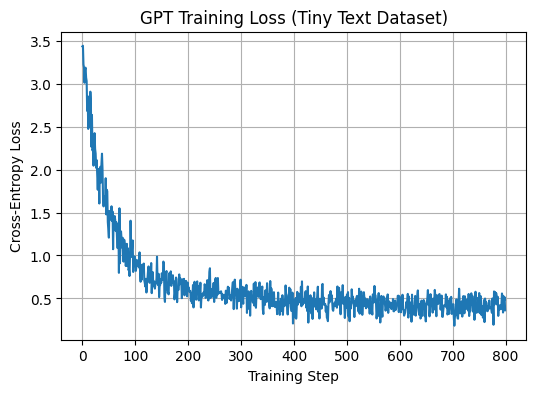

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Cross-Entropy Loss")
plt.title("GPT Training Loss (Tiny Text Dataset)")
plt.grid(True)
plt.show()


## 14. Autoregressive Text Generation

After training , the model generates the text autoregressively by predicting one token at a time using causal self-attention.

Generation stops when the `'<END>'` token is produced.

In [66]:
model.eval()

prompt = ["i", "love"]
prompt_ids = torch.tensor([[vocab[w] for w in prompt]], dtype=torch.long).to(device)

out = model.generate(prompt_ids, max_new_tokens=6)
print(" ".join(idx_to_token[i] for i in out[0].tolist()))


i love deep learning .
